# Cifar10 - exercicio de classificar 3 classes

Fazer classificação de 3 classes usando rede neural convolucional.
Não utilizar o pacote sklearn. Apenas o Keras e o NumPy.

Não utilizar a função de acompanhamento de gráficos durante o treinamento.

Gerar uma figura mosaic que contenha as 5 imagens de classificação correta de menor probabilidade de predição.

Gerar esta figura com o nome: cifar_fig.png

## Importação de bibliotecas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
import keras.regularizers as reg
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
import keras.backend as K
K.set_image_data_format('channels_first')
K.set_floatx('float32')

## Carregamento do dataset

In [3]:
data = np.load('/etc/jupyterhub/ia368z_2s2017/datasets/cifar10-redux.npz')

In [4]:
X = data['X_train']
y = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [5]:
X.shape, y.shape, X_test.shape, y_test.shape

((2000, 3, 32, 32), (2000,), (500, 3, 32, 32), (500,))

In [6]:
X.dtype, y.dtype, X_test.dtype, y_test.dtype

(dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('int64'))

## Ajuste dos dados

In [7]:
X = X.astype('float32')
X_test = X_test.astype('float32')
X_test /= 255.

# transforma labels em 0, 1 e 2, ao invés de 3, 4 e 5
y = y - 3
y_test = y_test - 3

## Definição do iterator para a geração de imagens

In [8]:
# definindo iterator do treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #featurewise_center=False,  # set input mean to 0 over the dataset
    #samplewise_center=False,  # set each sample mean to 0
    #featurewise_std_normalization=False,  # divide inputs by std of the dataset
    #samplewise_std_normalization=False,  # divide each input by its std
    #zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    #vertical_flip=False,  # randomly flip images
    shear_range=0.2,        # sorteio entre 0 e 0.2 distribuição uniforme
    zoom_range=0.2,         # sorteio entre 0 e 0.2
    data_format='channels_first')

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
#train_datagen.fit(X)

# definindo iterator do teste
validate_datagen = ImageDataGenerator(rescale=1./255)

## Mostrando alguns exemplos de imagens geradas

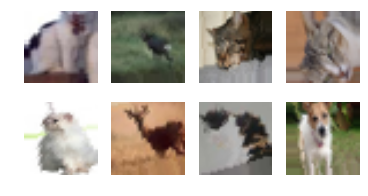

In [9]:
# Criação do generator
generator = train_datagen.flow(X, y, batch_size=8)

X_img, y_img = generator.next()

fig = plt.figure(figsize=(6,3))
for i, img in enumerate(X_img):
    fig.add_subplot(2, 4, i+1)
    plt.imshow(img.reshape(3,32,32).transpose((1,2,0)))

    plt.axis('off')

## Separação dos dados de treinamento em treinamento e validação

In [10]:
# numero de amostras
nb_data = X.shape[0]

# semente fixa para dar reproducibilidade
seed = 13
np.random.seed(seed)

msk = np.random.rand(nb_data) < 0.80
X_train = X[msk]
X_validate = X[~msk]
y_train = y[msk]
y_validate = y[~msk]

print(X_train.shape)
print(X_validate.shape)
print(y_train.shape)
print(y_validate.shape)

(1605, 3, 32, 32)
(395, 3, 32, 32)
(1605,)
(395,)


## Transforma o vetor de labels para o formato de one-hot encoding.

In [11]:
nb_classes = 3

y_oh = np_utils.to_categorical(y, nb_classes)
y_train_oh = np_utils.to_categorical(y_train, nb_classes)
y_validate_oh = np_utils.to_categorical(y_validate, nb_classes)
y_test_oh = np_utils.to_categorical(y_test, nb_classes)

## Construíndo a CNN com o Keras

In [12]:
img_rows, img_cols = 32, 32 # Dimensões das imagens
input_shape = (3, img_rows, img_cols)

# Definindo a rede
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(48,(3,3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Aqui os features deixam de ser imagens
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.75))
model.add(Dense(nb_classes, kernel_regularizer=reg.l2(0.025)))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 30, 30)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 30, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 28, 28)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 28, 28)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 12, 12)        27696     
__________

## Compilando a rede

In [13]:
loss = 'categorical_crossentropy'
#opt = RMSprop()
opt = Adam()

model.compile(loss=loss, optimizer=opt, metrics=["accuracy"]) 

## Callbacks

In [14]:
checkpointer = ModelCheckpoint(filepath='my_cifar_dataplus.hdf5', monitor='val_acc', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
lrreduction = ReduceLROnPlateau(monitor='val_acc', patience=7, verbose=1, factor=0.8, min_lr=0.00001)

## Treinamento da rede

In [15]:
batch_size = 10
epochs = 500

model.fit_generator(train_datagen.flow(X, y_oh,
                                       batch_size=batch_size),
                    steps_per_epoch=X.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(validate_datagen.flow(X, y_oh)),
                    validation_steps=X.shape[0] // batch_size,
                    callbacks=[checkpointer, earlystopper, lrreduction])

Epoch 1/500
200/200 [==============================] - 4s - loss: 1.1710 - acc: 0.3450 - val_loss: 1.1225 - val_acc: 0.3640
Epoch 2/500
200/200 [==============================] - 2s - loss: 1.1137 - acc: 0.3620 - val_loss: 1.1023 - val_acc: 0.3457
Epoch 3/500
200/200 [==============================] - 2s - loss: 1.1021 - acc: 0.3470 - val_loss: 1.0991 - val_acc: 0.3659
Epoch 4/500
200/200 [==============================] - 2s - loss: 1.0861 - acc: 0.4045 - val_loss: 1.0745 - val_acc: 0.5110
Epoch 5/500
200/200 [==============================] - 2s - loss: 1.0553 - acc: 0.4360 - val_loss: 1.0514 - val_acc: 0.3996
Epoch 6/500
200/200 [==============================] - 2s - loss: 1.0137 - acc: 0.4765 - val_loss: 0.9465 - val_acc: 0.5493
Epoch 7/500
200/200 [==============================] - 2s - loss: 0.9881 - acc: 0.5105 - val_loss: 0.9126 - val_acc: 0.5645
Epoch 8/500
200/200 [==============================] - 2s - loss: 0.9514 - acc: 0.5265 - val_loss: 0.9510 - val_acc: 0.5285
Epoch 9/

200/200 [==============================] - 2s - loss: 0.8161 - acc: 0.6380 - val_loss: 0.6853 - val_acc: 0.7105
Epoch 32/500
200/200 [==============================] - 2s - loss: 0.7926 - acc: 0.6570 - val_loss: 0.6843 - val_acc: 0.7084
Epoch 33/500
200/200 [==============================] - 2s - loss: 0.8078 - acc: 0.6325 - val_loss: 0.6781 - val_acc: 0.7264
Epoch 34/500
200/200 [==============================] - 2s - loss: 0.7914 - acc: 0.6410 - val_loss: 0.6819 - val_acc: 0.7165
Epoch 35/500
200/200 [==============================] - 2s - loss: 0.7818 - acc: 0.6580 - val_loss: 0.6937 - val_acc: 0.6902
Epoch 36/500
200/200 [==============================] - 2s - loss: 0.7684 - acc: 0.6580 - val_loss: 0.6535 - val_acc: 0.7226
Epoch 37/500
200/200 [==============================] - 2s - loss: 0.8023 - acc: 0.6275 - val_loss: 0.6621 - val_acc: 0.7264
Epoch 38/500
200/200 [==============================] - 2s - loss: 0.7642 - acc: 0.6645 - val_loss: 0.6650 - val_acc: 0.7223
Epoch 39/500


200/200 [==============================] - 2s - loss: 0.6863 - acc: 0.6975 - val_loss: 0.5355 - val_acc: 0.7953
Epoch 64/500
200/200 [==============================] - 2s - loss: 0.7169 - acc: 0.6825 - val_loss: 0.5273 - val_acc: 0.7928
Epoch 65/500
200/200 [==============================] - 2s - loss: 0.7099 - acc: 0.6930 - val_loss: 0.5537 - val_acc: 0.7767
Epoch 66/500
200/200 [==============================] - 2s - loss: 0.7171 - acc: 0.6915 - val_loss: 0.5433 - val_acc: 0.7933
Epoch 67/500
200/200 [==============================] - 2s - loss: 0.7064 - acc: 0.6940 - val_loss: 0.5571 - val_acc: 0.7827
Epoch 68/500
200/200 [==============================] - 2s - loss: 0.7027 - acc: 0.6955 - val_loss: 0.5636 - val_acc: 0.7968
Epoch 69/500
200/200 [==============================] - 2s - loss: 0.7156 - acc: 0.6955 - val_loss: 0.5584 - val_acc: 0.7831
Epoch 70/500
200/200 [==============================] - 2s - loss: 0.6915 - acc: 0.7050 - val_loss: 0.5526 - val_acc: 0.7780
Epoch 71/500


200/200 [==============================] - 2s - loss: 0.5960 - acc: 0.7435 - val_loss: 0.3922 - val_acc: 0.8641
Epoch 129/500
200/200 [==============================] - 2s - loss: 0.5709 - acc: 0.7585 - val_loss: 0.3906 - val_acc: 0.8566
Epoch 130/500
200/200 [==============================] - 2s - loss: 0.5658 - acc: 0.7645 - val_loss: 0.3819 - val_acc: 0.8637
Epoch 131/500
200/200 [==============================] - 2s - loss: 0.5840 - acc: 0.7665 - val_loss: 0.4034 - val_acc: 0.8640
Epoch 132/500
200/200 [==============================] - 2s - loss: 0.5824 - acc: 0.7615 - val_loss: 0.3897 - val_acc: 0.8629
Epoch 133/500
200/200 [==============================] - 2s - loss: 0.5725 - acc: 0.7595 - val_loss: 0.3669 - val_acc: 0.8744
Epoch 134/500
200/200 [==============================] - 2s - loss: 0.5679 - acc: 0.7550 - val_loss: 0.3758 - val_acc: 0.8684
Epoch 135/500
200/200 [==============================] - 2s - loss: 0.5698 - acc: 0.7725 - val_loss: 0.3710 - val_acc: 0.8725
Epoch 

200/200 [==============================] - 2s - loss: 0.4991 - acc: 0.7950 - val_loss: 0.3037 - val_acc: 0.8915
Epoch 194/500
200/200 [==============================] - 2s - loss: 0.5256 - acc: 0.7900 - val_loss: 0.2895 - val_acc: 0.9186
Epoch 195/500
200/200 [==============================] - 2s - loss: 0.4776 - acc: 0.8150 - val_loss: 0.2859 - val_acc: 0.9127
Epoch 196/500
200/200 [==============================] - 2s - loss: 0.4874 - acc: 0.8050 - val_loss: 0.3120 - val_acc: 0.8977
Epoch 197/500
200/200 [==============================] - 2s - loss: 0.5240 - acc: 0.7865 - val_loss: 0.2879 - val_acc: 0.9076
Epoch 198/500
200/200 [==============================] - 2s - loss: 0.5183 - acc: 0.7890 - val_loss: 0.2871 - val_acc: 0.9148
Epoch 199/500
200/200 [==============================] - 2s - loss: 0.5029 - acc: 0.7920 - val_loss: 0.3001 - val_acc: 0.9113
Epoch 200/500
200/200 [==============================] - 2s - loss: 0.4945 - acc: 0.7920 - val_loss: 0.2902 - val_acc: 0.9046
Epoch 

200/200 [==============================] - 2s - loss: 0.4398 - acc: 0.8285 - val_loss: 0.2188 - val_acc: 0.9405
Epoch 258/500
200/200 [==============================] - 2s - loss: 0.4091 - acc: 0.8285 - val_loss: 0.2220 - val_acc: 0.9339
Epoch 259/500
200/200 [==============================] - 2s - loss: 0.4267 - acc: 0.8295 - val_loss: 0.2161 - val_acc: 0.9378
Epoch 260/500
200/200 [==============================] - 2s - loss: 0.4403 - acc: 0.8280 - val_loss: 0.2298 - val_acc: 0.9358
Epoch 261/500
200/200 [==============================] - 2s - loss: 0.4275 - acc: 0.8305 - val_loss: 0.2282 - val_acc: 0.9312
Epoch 262/500
200/200 [==============================] - 2s - loss: 0.4249 - acc: 0.8340 - val_loss: 0.2185 - val_acc: 0.9369
Epoch 263/500
200/200 [==============================] - 2s - loss: 0.4349 - acc: 0.8260 - val_loss: 0.2224 - val_acc: 0.9400
Epoch 264/500
200/200 [==============================] - 2s - loss: 0.4098 - acc: 0.8370 - val_loss: 0.2177 - val_acc: 0.9381
Epoch 

200/200 [==============================] - 2s - loss: 0.3899 - acc: 0.8435 - val_loss: 0.2002 - val_acc: 0.9414
Epoch 323/500
200/200 [==============================] - 2s - loss: 0.4115 - acc: 0.8415 - val_loss: 0.1970 - val_acc: 0.9437
Epoch 324/500
200/200 [==============================] - 2s - loss: 0.3998 - acc: 0.8415 - val_loss: 0.1989 - val_acc: 0.9451
Epoch 325/500
200/200 [==============================] - 2s - loss: 0.3971 - acc: 0.8300 - val_loss: 0.1975 - val_acc: 0.9474
Epoch 326/500
200/200 [==============================] - 2s - loss: 0.4026 - acc: 0.8405 - val_loss: 0.1970 - val_acc: 0.9425
Epoch 327/500
200/200 [==============================] - 2s - loss: 0.3900 - acc: 0.8450 - val_loss: 0.1944 - val_acc: 0.9467
Epoch 328/500
200/200 [==============================] - 2s - loss: 0.4082 - acc: 0.8360 - val_loss: 0.1938 - val_acc: 0.9457
Epoch 329/500
200/200 [==============================] - 2s - loss: 0.3890 - acc: 0.8370 - val_loss: 0.1998 - val_acc: 0.9419
Epoch 

## Apaga modelo atual

In [16]:
del model

## Carrega modelo salvo em disco

In [17]:
model = load_model('my_cifar_dataplus.hdf5')

## Avaliação do treinamento no conjunto de testes com o melhor modelo

In [18]:
loss, accuracy = model.evaluate(X_test, y_test_oh, batch_size=10)
print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

420/500 [========================>.....] - ETA: 0s
[INFO] accuracy on the test data set: 75.40% [0.68947]
